# Introduction

I fell into a 'stochastic trap' recently when running experiments with random variables.

Lets say there is a population of 1000 football players. We want to form a team of the best 11. We imagine the ratings of the players are distributed normally (Gaussian). We can run such a hypothetical experiment as follows.

In [14]:
import random


def get_team(population, n=11):
    '''for a gaussian population of the given size, returns (a, b) where 
    a = the rating of the n'th best player
    b = the rating of the best player
    '''
    players = [random.gauss(mu=0, sigma=2) for x in range(population)]
    players.sort()
    return players[-n:]

team = get_team(1000, 11) 
print(f"the ratings of the team are: {team}")

the ratings of the team are: [4.786297465588625, 4.849655628517978, 4.949423553182096, 4.992252508406897, 5.14117304064939, 5.248476800382806, 5.2572488670371085, 5.430446103421893, 5.567310503008709, 5.778318528899001, 7.6273682577180475]


Next lets say we want to find out how well our best player would fare in a larger population of 10000 players. We could generate a population of 10000 and rank our player against that population as follows.

In [15]:
from bisect import bisect


def get_rank(population, rating):
    '''returns rank (best = 0) of the rating in a gaussian population of given size'''
    players = [random.gauss(mu=0, sigma=2) for x in range(population)]
    players.sort()
    rank = bisect(players, rating)
    return population - rank

print(f"the best from 1000 is ranked (0 best): {get_rank(10000, team[-1])}")

the best from 1000 is ranked (0 best): 0


# The Experiment

But that is just one instance of a team selected from 1000 and one instance of a population of 10,000. We want to figure out some kind of expectation.

We could do it this way:
- Step 1) find out the average best player from population of 1000
- Step 2) compare that average with a number of populations of 10000 - we'll take the average rank

As follows ...

In [17]:
from statistics import mean

def experiment():
    ave_best_from_1000 = mean([get_team(1000)[-1] for team in range(1000)])
    ave_rank_in_10000 = mean([get_rank(10000, ave_best_from_1000) for population in range(1000)])
    return ave_best_from_1000, ave_rank_in_10000

ave_best_from_1000, ave_rank_in_10000 = experiment()
print(f"average best rating from population of 1000: {ave_best_from_1000}")
print(f"average rank in 10000: {ave_rank_in_10000}")

average best rating from population of 1000: 6.494049595120885
average rank in 10000: 5.818


Below we look at how tightly results from this method are distributed. We can see that this method gives us a very consistent result.

In [ ]:
# WARNING long running code
a = [experiment()[0] for i in range(100)]

In [26]:
from statistics import mean, stdev

print(f"mean: {mean(a)}, stdev: {stdev(a)}")

mean: 6.4875069465655155, stdev: 0.02137751794594949


# The problem

The problem with that method is that in Step 1), by taking the average at that point, we lose a lot of information about what kinds of best player we get in that smaller population. We can take a look at the distribution of the ratings of those best players as follows. We see that the distribution is skewed and therefore we should use the average with more care.

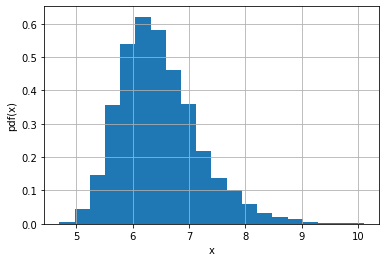

In [16]:
import matplotlib.pyplot as plt


def plot_experiment(data_function, title=None, bins=20, density=True, cumulative=False):
    '''
    density: if True plot density (density = counts / (sum(counts) * np.diff(bins)))
    '''
    fig, ax = plt.subplots()
    xs = data_function()
    
    ax.hist(xs, bins=bins, density=density, cumulative=cumulative)
    ax.set_xlabel('x')
    ax.set_ylabel('pdf(x)')
    if title:
        ax.set_title(title)
    ax.grid(True)


best_players = [get_team(1000)[-1] for i in range(10000)]
plot_experiment(lambda: best_players)


# Solution 1

A better way to find out how our best players from smaller populations will do in the larger populations is to discover a player from one random small population and compare each of them to a random larger population.

In [17]:
ave_rank_in_10K_1by1 = mean([
    get_rank(10000, get_team(1000)[-1]) 
        for x in range(10000)
])
print(f"average rank in 10000: {ave_rank_in_10K_1by1}")

average rank in 10000: 9.8833


The average rank is significantly different. Approximately 10 vs 6. The outcome of this experiment is very reliable but I don't include the code to demonstrate this as it is quite computationally expensive.


# Solution 2

The above is computationaly much more expensive than Solution 1 as for each trial we generate a population of 1000 and another population of 10000. Lets see if we can only generate a single population of 10000 that we can reuse. Below we will see what kind of distribution of rank we get when we reuse a larger population over and over.

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

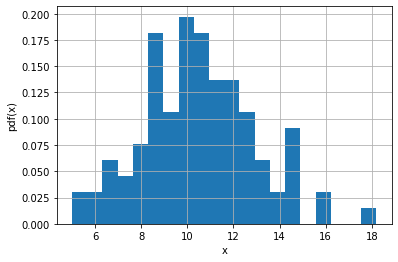

In [27]:
def get_rank_given_population(players, rating):
    '''returns rank (best = 0) of the rating in a gaussian population of given size'''
    rank = bisect(players, rating)
    return len(players) - rank


def single_population_experiment():
    players = [random.gauss(mu=0, sigma=2) for x in range(10000)]
    players.sort()
    ave_rank = mean([
        get_rank_given_population(players, get_team(1000)[-1]) 
            for x in range(1000) # cut down to 1000 to reduce computation time
    ])
    return ave_rank


ranks = []
for i in range(100):
    r = single_population_experiment()
    print(i, end=", ")
    ranks.append(r)

plot_experiment(lambda: ranks)


We can see that the average result clusters around our expected value of ~10. However we would not want to trust any single run of this experiment. Solution 1 is a better bet.